Case Study 2:

In [ ]:
import pandas as pd

# import alive
dataset = pd.read_csv("../case_study_2/python/data/total_cells.csv")
ehux_cells = dataset.tail(15)
ehux_total_time = ehux_cells['Time (days)'].values
ehux_total_density = 1e6*ehux_cells[' Density (1e6/ml)'].values

# import dead
death_dataset = pd.read_csv("../case_study_2/python/data/death_percentage.csv")
ehux_death = death_dataset.head(15)
ehux_dead_time = ehux_death['Time (days)']
ehux_dead_density = ehux_death[' Dead percentage '].values*ehux_total_density/100


$$
\frac{dP}{dt} = r P_0 \left(1 - \frac{P_0}{K}\right)
$$

$$
P(t) = \frac{K}{1 + \left(\frac{K - P_0}{P_0}\right) e^{-rt}}
$$


In [2]:
def logistic_growth(y, t, params):
    # Use indexing instead of unpacking
    P = y[0]
    
    r = params[0]
    K = params[1]
    
    return r * (1 - P / K) * P 

In [3]:
import pymc as pm
cell_model = pm.ode.DifferentialEquation(
    func=logistic_growth,
    times=ehux_total_time,
    n_states=1,
    n_theta=2,
    t0=0
)

c:\Users\Whisk\miniconda3\envs\MCMC_modeling\Lib\site-packages\pytensor\link\c\cmodule.py:2968: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(


In [4]:
def ode_solution2data(solution):
    """
    User-defined function to extract and compute useful outputs from the ODE solution.
    
    Args:
        solution (np.ndarray): shape (time_points, num_variables)

    Returns:
        dict: keys are output variable names, values are 1D arrays over time
    """
    
    total = solution[:, 0]  # Assuming the first column is the total cell count
    return {
        "total": total
    }

In [5]:
import numpy as np
with pm.Model() as model:
    # Priors
    r = pm.Uniform(r"$r$ (growth rate)", lower=0.5, upper=1)
    K = pm.Uniform(r"$K$ (carrying capacity)" , lower=1e6, upper=4e7)
    P0 = pm.Uniform(r"$P_0$ (init. live)", lower=1e5, upper=3e5)
    sigma_live = pm.HalfNormal(r"$\sigma_L$", 3)

    # Solve the ODE system
    y_hat = cell_model(y0=[P0], theta=[r,K])
    y_hat_sol = ode_solution2data(y_hat)
    # Extract live and dead cell solutions
    #total_solution = y_hat_sol['total']
    total_solution = y_hat_sol['total']  # Match observed shape

    # pymc multiplies this itself (or additive after taking Log of Likelihood.)
    pm.Normal("Y_total", mu=pm.math.log(pm.math.clip(total_solution, 1e-8, np.inf)),sigma=sigma_live,
            observed =  np.log(ehux_total_density))   


In [6]:
with model:
    trace = pm.sample(draws=2000, tune=500, chains=3, return_inferencedata=True, target_accept=0.95, cores = 3) 

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [$r$ (growth rate), $K$ (carrying capacity), $P_0$ (init. live), $\sigma_L$]


c:\Users\Whisk\miniconda3\envs\MCMC_modeling\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 3 chains for 500 tune and 2_000 draw iterations (1_500 + 6_000 draws total) took 221 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


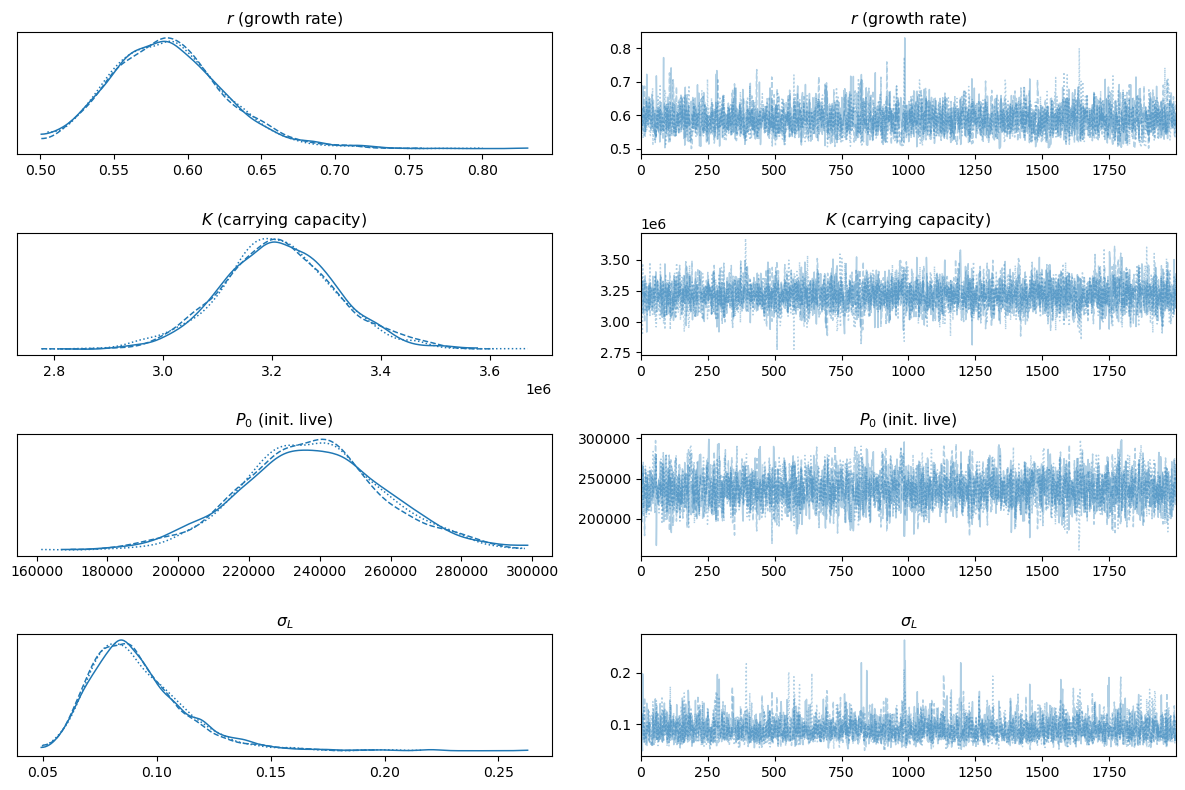

In [7]:
import arviz as az
import matplotlib.pyplot as plt
az.plot_trace(trace)
plt.tight_layout()
plt.show()

$$
\frac{dP}{dt} = r P \left(1 - \frac{P}{K}\right) - \delta P
$$

$$
P(t) = \frac{K}{1 + \left(\frac{K - P_0}{P_0}\right) e^{-rt}}
$$

$$
\frac{dD}{dt} = \delta P
$$

$$
y(t) = y_0 e^{\mu t}
$$


Case Study 2: Growth and Death

In [13]:
def logistic_growth_death(y, t, params):
    # Use indexing instead of unpacking
    P = y[0]
    D = y[1]
    r = params[0]
    K = params[1]
    delta = params[2]

    dydt = [0, 0]
    dydt[0] = r * (1 - P / K) * P - delta * P
    dydt[1] = delta * P
    return dydt

In [14]:
cell_model = pm.ode.DifferentialEquation(
    func=logistic_growth_death,
    times=ehux_total_time,
    n_states=2,
    n_theta=3, # because rest goes in y0 
    t0=0
)

In [15]:
def ode_solution2data(solution):
    """
    User-defined function to extract and compute useful outputs from the ODE solution.
    
    Args:
        solution (np.ndarray): shape (time_points, num_variables)

    Returns:
        dict: keys are output variable names, values are 1D arrays over time
    """
    live = solution[:, 0]
    dead = solution[:, 1]
    total = live + dead
    return {
        "total": total,
        "dead": dead
    }

In [16]:
with pm.Model() as model:
    # Priors
    r = pm.Uniform(r"$r$ (growth rate)", lower=0.5, upper=1)
    K = pm.Uniform(r"$K$ (carrying capacity)" , lower=1e6, upper=4e7)
    delta = pm.Uniform(r"$\delta$ (death rate)", lower=0.0, upper=0.15)
    P0 = pm.Uniform(r"$P_0$ (init. live)", lower=1e5, upper=3e5)
    D0 = pm.Uniform(r"$D_0$ (init. dead)", lower=1e4, upper=7e4)

    sigma_live = pm.HalfNormal(r"$\sigma_L$", 3)
    sigma_dead = pm.HalfNormal(r"$\sigma_D$", 3)

    # Solve the ODE system
    y_hat = cell_model(y0=[P0,D0], theta=[r,K,delta])
    y_hat_sol = ode_solution2data(y_hat)
    # Extract live and dead cell solutions
    total_solution = y_hat_sol['total']
    dead_solution = y_hat_sol['dead']

    # pymc multiplies this itself (or additive after taking Log of Likelihood.)
    pm.Normal("Y_live", mu=pm.math.log(pm.math.clip(total_solution, 1e-8, np.inf)),sigma=sigma_live,
            observed =  np.log(ehux_total_density))

    pm.Normal("Y_dead", mu=pm.math.log(pm.math.clip(dead_solution, 1e-8, np.inf)),sigma=sigma_dead,
            observed=np.log(ehux_dead_density))

In [17]:
with model:
    trace = pm.sample(draws=2000, tune=500, chains=3, return_inferencedata=True, target_accept=0.95, cores = 3) 

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [$r$ (growth rate), $K$ (carrying capacity), $\delta$ (death rate), $P_0$ (init. live), $D_0$ (init. dead), $\sigma_L$, $\sigma_D$]


c:\Users\Whisk\miniconda3\envs\MCMC_modeling\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 3 chains for 500 tune and 2_000 draw iterations (1_500 + 6_000 draws total) took 1135 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


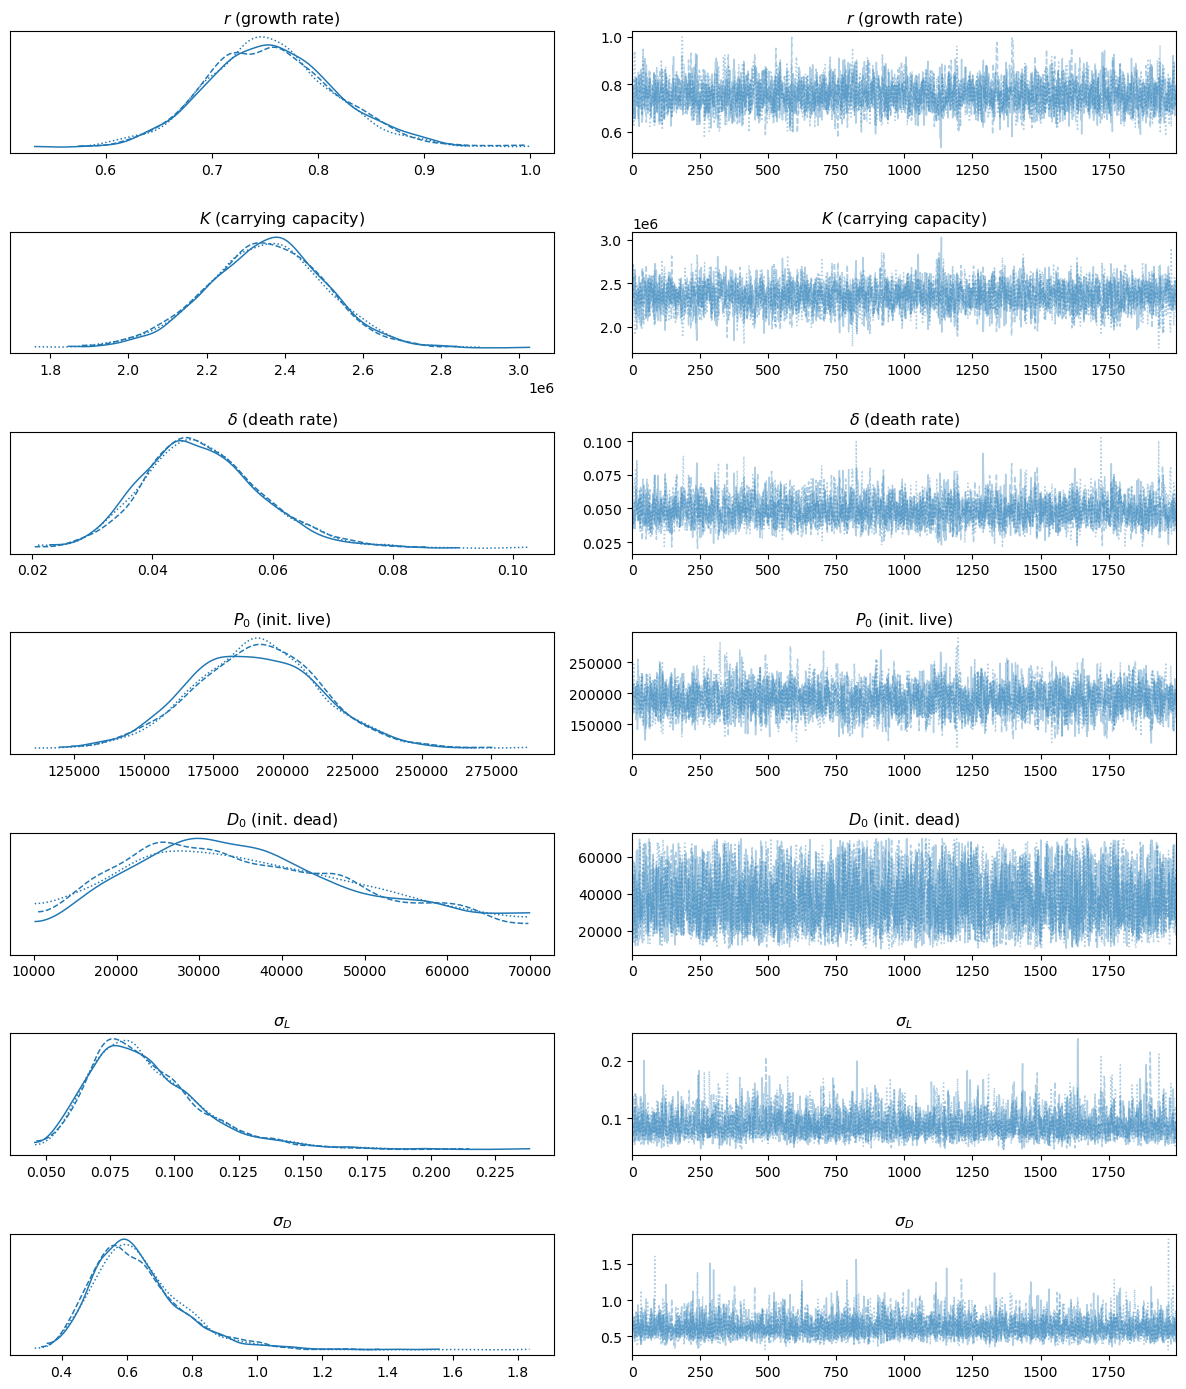

In [18]:
import arviz as az
import matplotlib.pyplot as plt
az.plot_trace(trace)
plt.tight_layout()
plt.show()